In [12]:
from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [13]:
# Load images and labels
IMAGES = Path("data/unzipped/images_training_rev1")
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [14]:
data.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [15]:
def image_preprocess(id):
    # Read in the image
    img = cv2.imread(IMAGES / (str(id) + ".jpg"))

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Crop the image to 192x192 centered on the center pixel
    center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
    start_x, start_y = center_x - 96, center_y - 96
    img = img[start_y : start_y + 192, start_x : start_x + 192]

    # Downsample to 64x64
    img = cv2.resize(img, (64, 64))

    # Normalize to [0, 1]
    img = img.astype("float32") / 255

    return img


In [16]:
def label_preprocess(data, row):
    columns = data.columns
    return np.array([data.iloc[row][columns[1:-2]].to_numpy()]).astype(np.float32)

## Model Definition

In [17]:
# Define a torch model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=35)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x

## Training

In [18]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [19]:
def prep_data(data: pd.DataFrame, test_size: float = 0.2, val_size: float = 0.5):
    # Split data into train and test
    train_data, test_data = train_test_split(data, test_size=test_size)
    test_data, val_data = train_test_split(test_data, test_size=val_size)

    # Convert images to numpy array
    train_data["image"] = train_data["GalaxyID"].apply(lambda x: image_preprocess(x))
    test_data["image"] = test_data["GalaxyID"].apply(lambda x: image_preprocess(x))
    val_data["image"] = val_data["GalaxyID"].apply(lambda x: image_preprocess(x))

    # Convert labels to numpy array
    train_data["label"] = train_data.apply(lambda x: label_preprocess(data, x.name), axis=1)
    test_data["label"] = test_data.apply(lambda x: label_preprocess(data, x.name), axis=1)
    val_data["label"] = val_data.apply(lambda x: label_preprocess(data, x.name), axis=1)

    # Convert images to torch tensor as input
    train_input = torch.Tensor(np.stack(train_data["image"].to_numpy())).permute(0, 3, 1, 2)
    test_input = torch.Tensor(np.stack(test_data["image"].to_numpy())).permute(0, 3, 1, 2)
    val_input = torch.Tensor(np.stack(val_data["image"].to_numpy())).permute(0, 3, 1, 2)

    # Convert labels to torch tensor as output
    train_output = torch.Tensor(np.stack(train_data["label"].to_numpy())).squeeze(1)
    test_output = torch.Tensor(np.stack(test_data["label"].to_numpy())).squeeze(1)
    val_output = torch.Tensor(np.stack(val_data["label"].to_numpy())).squeeze(1)

    return (train_input, train_output), (test_input, test_output), (val_input, val_output)

In [20]:
# Create train, test, and validation sets
(train_input, train_output), (test_input, test_output), (val_input, val_output) = prep_data(data)

In [21]:
print(f"Training input shape: {train_input.shape}\nTraining output shape: {train_output.shape}")

Training input shape: torch.Size([49262, 3, 64, 64])
Training output shape: torch.Size([49262, 35])


In [22]:
# Instantiate the model
model = Model()

In [23]:
# Move model and data to device
model = model.to(DEVICE)
train_input = train_input.to(DEVICE)
train_output = train_output.to(DEVICE)

test_input = test_input.to(DEVICE)
test_output = test_output.to(DEVICE)

In [24]:
# Run a single image through the model
model_output = model(train_input[0].unsqueeze(0))
print(f"Model output shape: {model_output.shape}")

Model output shape: torch.Size([1, 36])


In [25]:
# Define the training and testing functions
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
    test_loss /= len(test_loader)
    return test_loss


def train(
    model: torch.nn.Module,
    epochs: int,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LRScheduler,
    criterion: torch.nn.Module,
):
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            # Run data through model and calculate loss
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Backpropagate
            loss.backward()
            optimizer.step()

            # Logging
            epoch_loss += loss.item()
            if batch_idx % 100 == 0:
                print(
                    "{} Train Epoch: {:>4} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        datetime.now().strftime("%m/%d %H:%M:%S"),
                        epoch,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    ),
                    end="\r",
                )

        scheduler.step()

        # Calculate performance on test set
        test_loss = test(model, test_loader, criterion)
        print(
            "{} Train Epoch: {:>4} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}\tTest Loss: {:.6f}".format(
                datetime.now().strftime("%m/%d %H:%M:%S"),
                epoch,
                len(train_loader.dataset),
                len(train_loader.dataset),
                100.0,
                epoch_loss / len(train_loader),
                test_loss,
            )
        )

        # Track loss on train and test sets
        train_losses.append(epoch_loss / len(train_loader))
        test_losses.append(test_loss)

    return train_losses, test_losses

In [26]:
# Training Parameters
EPOCHS = 200
BATCH_SIZE = 64
LR = 0.001
GAMMA = 0.99

In [27]:
# Create a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Competition requested MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [28]:
# Create a data loader for the training data
train_dataset = torch.utils.data.TensorDataset(train_input, train_output)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a data loader for the test data
test_dataset = torch.utils.data.TensorDataset(test_input, test_output)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [31]:
# Train the model
train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

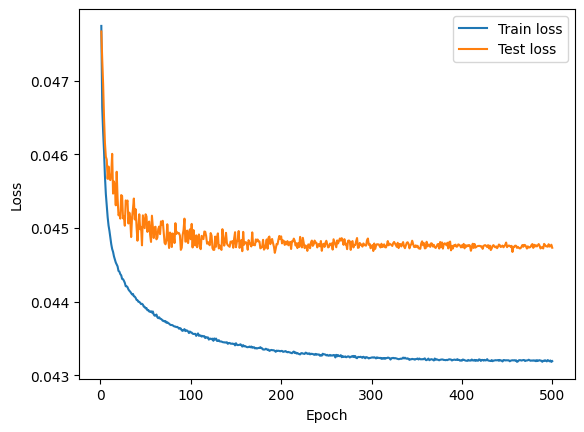

In [50]:
# Plot losses
plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [51]:
# Test against validation set
# Create a data loader for the training data
val_dataset = torch.utils.data.TensorDataset(val_input, val_output)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_loss = test(model, val_loader, criterion)
print(f"Training loss:\t\t{train_loss[-1]}")
print(f"Testing loss:\t\t{test_loss[-1]}")
# print(f"Validation loss:\t{val_loss}")

Training loss:		0.043190911760577905
Testing loss:		0.044731233576216646


In [52]:
# New model
model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_E{EPOCHS}_B{BATCH_SIZE}_LR{LR}_GAMMA{GAMMA}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"

# Old model
# model_name = "241114201016_model_E000_B000_LR0.00_GAMMA0.00_TRAIN_0.0000_TEST0.0000"

In [53]:
# Save the model
torch.save(model.state_dict(), "models/cross_entropy/" + model_name)
print(f"Model saved as {model_name}")

Model saved as 241118090817_model_E500_B64_LR0.001_GAMMA0.99_TRAIN0.0432_TEST0.0447.pth


In [54]:
# Load the model
model = Model()
model.load_state_dict(torch.load("models/cross_entropy/" + model_name))
model.to(DEVICE)

C:\Users\ethan\AppData\Local\Temp\ipykernel_1164292\3340224069.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/" + model_name))


Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

## Hyperparameter Tuning

In [25]:
# Parameters
EPOCHS = 200
BATCH_SIZE = [16, 32, 64, 128, 256]
LR = [0.01, 0.001, 0.0001]
GAMMA = [0.9, 0.95, 0.99]

Training model with batch size 16, lr 0.01, gamma 0.9
11/16 23:20:06 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.072897	Test Loss: 0.073021
11/16 23:20:15 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.072917	Test Loss: 0.073021
11/16 23:20:25 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.072916	Test Loss: 0.073021
11/16 23:20:36 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.072917	Test Loss: 0.073021
11/16 23:20:46 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.072917	Test Loss: 0.073021
11/16 23:20:56 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.072917	Test Loss: 0.073021
11/16 23:21:06 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.072916	Test Loss: 0.073021
11/16 23:21:16 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.072917	Test Loss: 0.073021
11/16 23:21:26 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.072917	Test Loss: 0.073021
11/16 23:21:36 Train Epoch:   10 [49262/49262 (100%)]	Train Loss: 0.072916	Test Loss: 0.073

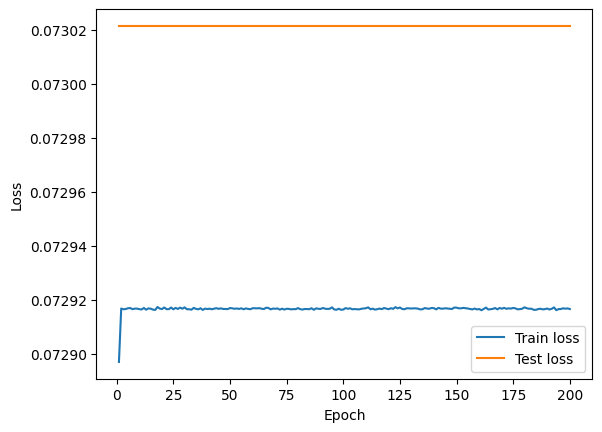

Model saved as 241117000223_model_E200_B16_LR0.01_GAMMA0.9_TRAIN0.0729_TEST0.0730.pth
Training model with batch size 16, lr 0.01, gamma 0.95
11/17 00:02:36 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047563	Test Loss: 0.049026
11/17 00:02:49 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047035	Test Loss: 0.047138
11/17 00:03:02 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046905	Test Loss: 0.047151
11/17 00:03:16 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046806	Test Loss: 0.046825
11/17 00:03:29 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046720	Test Loss: 0.047139
11/17 00:03:42 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046643	Test Loss: 0.046853
11/17 00:03:55 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046500	Test Loss: 0.046696
11/17 00:04:08 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046448	Test Loss: 0.046766
11/17 00:04:21 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046360	Test Loss: 0.046459
11/1

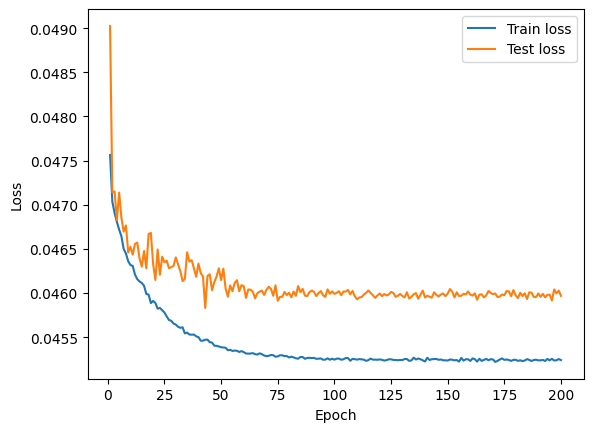

Model saved as 241117004626_model_E200_B16_LR0.01_GAMMA0.95_TRAIN0.0452_TEST0.0460.pth
Training model with batch size 16, lr 0.01, gamma 0.99
11/17 00:46:39 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.060308	Test Loss: 0.060877
11/17 00:46:52 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.060306	Test Loss: 0.060877
11/17 00:47:05 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060877
11/17 00:47:19 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.060306	Test Loss: 0.060877
11/17 00:47:32 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060877
11/17 00:47:45 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.060306	Test Loss: 0.060877
11/17 00:47:58 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060877
11/17 00:48:11 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060877
11/17 00:48:25 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060877
11/

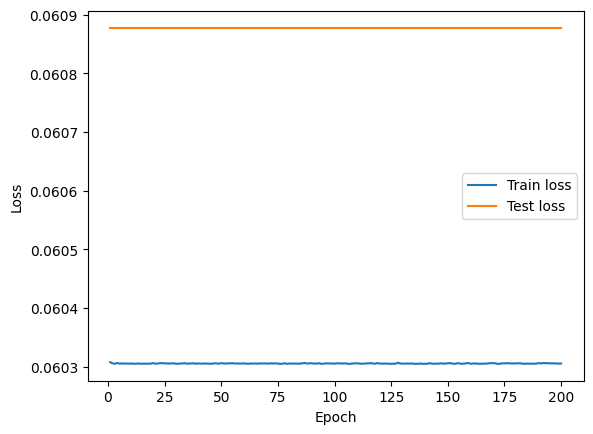

Model saved as 241117013036_model_E200_B16_LR0.01_GAMMA0.99_TRAIN0.0603_TEST0.0609.pth
Training model with batch size 16, lr 0.001, gamma 0.9
11/17 01:30:50 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047359	Test Loss: 0.047161
11/17 01:31:03 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046495	Test Loss: 0.046793
11/17 01:31:16 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046023	Test Loss: 0.046109
11/17 01:31:29 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045603	Test Loss: 0.046094
11/17 01:31:43 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045347	Test Loss: 0.046000
11/17 01:31:56 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045157	Test Loss: 0.046304
11/17 01:32:09 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045035	Test Loss: 0.045916
11/17 01:32:22 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.044916	Test Loss: 0.045844
11/17 01:32:35 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044817	Test Loss: 0.045639
11/

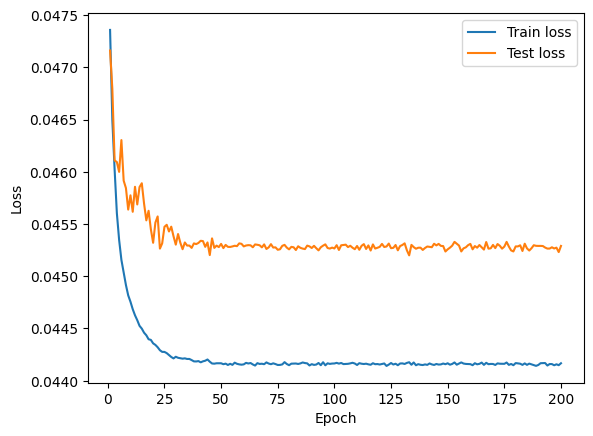

Model saved as 241117021431_model_E200_B16_LR0.001_GAMMA0.9_TRAIN0.0442_TEST0.0453.pth
Training model with batch size 16, lr 0.001, gamma 0.95
11/17 02:14:44 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047276	Test Loss: 0.046915
11/17 02:14:58 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046335	Test Loss: 0.046545
11/17 02:15:11 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.045793	Test Loss: 0.046056
11/17 02:15:24 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045487	Test Loss: 0.046119
11/17 02:15:37 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045299	Test Loss: 0.046348
11/17 02:15:51 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045159	Test Loss: 0.046073
11/17 02:16:04 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045042	Test Loss: 0.045929
11/17 02:16:17 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.044950	Test Loss: 0.045948
11/17 02:16:30 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044867	Test Loss: 0.046013
11

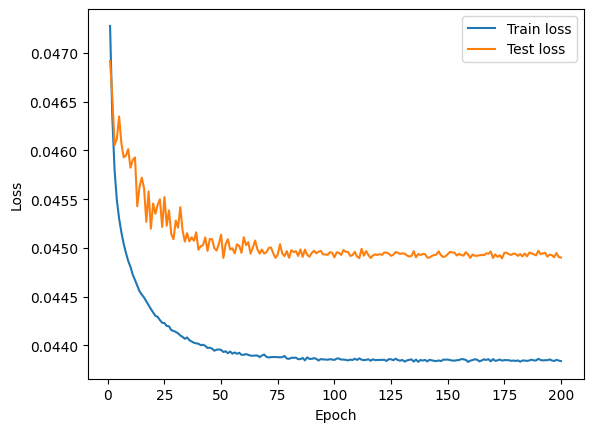

Model saved as 241117025828_model_E200_B16_LR0.001_GAMMA0.95_TRAIN0.0438_TEST0.0449.pth
Training model with batch size 16, lr 0.001, gamma 0.99
11/17 02:58:41 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047275	Test Loss: 0.047292
11/17 02:58:54 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046409	Test Loss: 0.046473
11/17 02:59:07 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.045866	Test Loss: 0.046157
11/17 02:59:20 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045534	Test Loss: 0.045908
11/17 02:59:33 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045319	Test Loss: 0.046028
11/17 02:59:47 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045160	Test Loss: 0.045607
11/17 03:00:00 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045039	Test Loss: 0.045707
11/17 03:00:13 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.044930	Test Loss: 0.045730
11/17 03:00:26 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044827	Test Loss: 0.045366
1

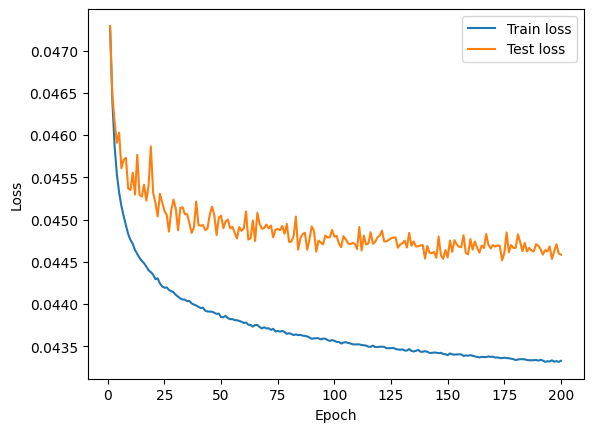

Model saved as 241117034223_model_E200_B16_LR0.001_GAMMA0.99_TRAIN0.0433_TEST0.0446.pth
Training model with batch size 16, lr 0.0001, gamma 0.9
11/17 03:42:37 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048100	Test Loss: 0.047633
11/17 03:42:50 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046995	Test Loss: 0.047324
11/17 03:43:03 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046792	Test Loss: 0.047318
11/17 03:43:16 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046618	Test Loss: 0.047041
11/17 03:43:30 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046420	Test Loss: 0.046891
11/17 03:43:43 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046250	Test Loss: 0.046822
11/17 03:43:56 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046105	Test Loss: 0.046703
11/17 03:44:10 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046010	Test Loss: 0.046929
11/17 03:44:23 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045930	Test Loss: 0.046712
1

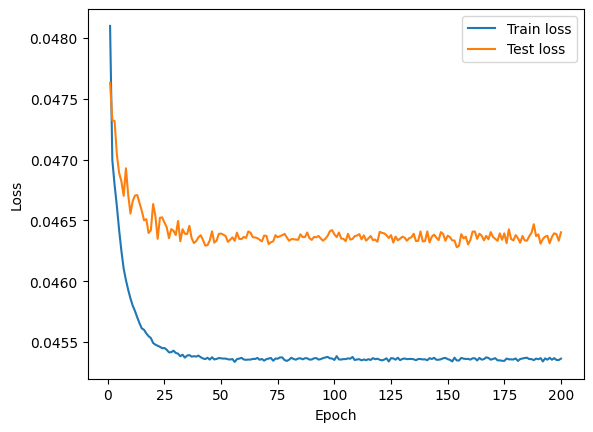

Model saved as 241117042624_model_E200_B16_LR0.0001_GAMMA0.9_TRAIN0.0454_TEST0.0464.pth
Training model with batch size 16, lr 0.0001, gamma 0.95
11/17 04:26:37 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048121	Test Loss: 0.047571
11/17 04:26:51 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047067	Test Loss: 0.047276
11/17 04:27:04 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046778	Test Loss: 0.047100
11/17 04:27:17 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046486	Test Loss: 0.046801
11/17 04:27:30 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046239	Test Loss: 0.046681
11/17 04:27:43 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046068	Test Loss: 0.046505
11/17 04:27:56 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045960	Test Loss: 0.046344
11/17 04:28:09 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045845	Test Loss: 0.046410
11/17 04:28:23 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045768	Test Loss: 0.046392


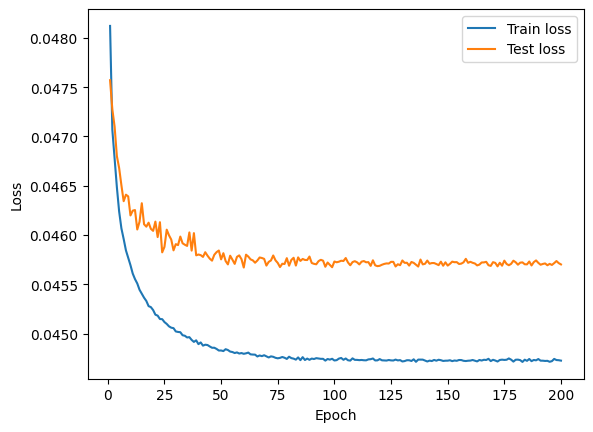

Model saved as 241117051017_model_E200_B16_LR0.0001_GAMMA0.95_TRAIN0.0447_TEST0.0457.pth
Training model with batch size 16, lr 0.0001, gamma 0.99
11/17 05:10:31 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048216	Test Loss: 0.047724
11/17 05:10:44 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047049	Test Loss: 0.047275
11/17 05:10:57 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046733	Test Loss: 0.047190
11/17 05:11:10 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046429	Test Loss: 0.046923
11/17 05:11:23 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046166	Test Loss: 0.046661
11/17 05:11:36 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046020	Test Loss: 0.046659
11/17 05:11:50 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045858	Test Loss: 0.046914
11/17 05:12:03 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045725	Test Loss: 0.046410
11/17 05:12:16 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045633	Test Loss: 0.046692

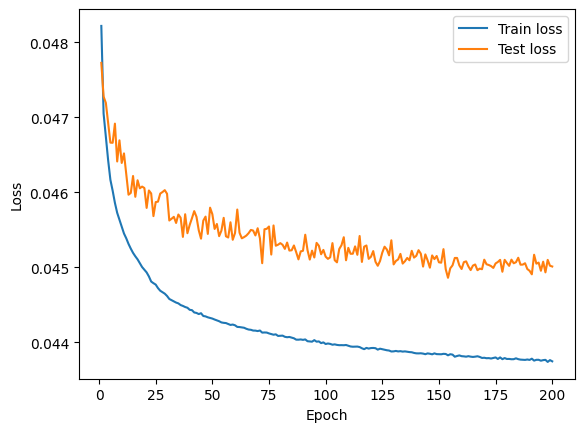

Model saved as 241117055415_model_E200_B16_LR0.0001_GAMMA0.99_TRAIN0.0437_TEST0.0450.pth
Training model with batch size 32, lr 0.01, gamma 0.9
11/17 05:54:22 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.060302	Test Loss: 0.060911
11/17 05:54:29 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.060310	Test Loss: 0.060911
11/17 05:54:36 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.060307	Test Loss: 0.060911
11/17 05:54:43 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060911
11/17 05:54:50 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.060303	Test Loss: 0.060911
11/17 05:54:57 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.060309	Test Loss: 0.060911
11/17 05:55:04 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.060311	Test Loss: 0.060911
11/17 05:55:11 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.060309	Test Loss: 0.060911
11/17 05:55:18 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.060299	Test Loss: 0.060911
11

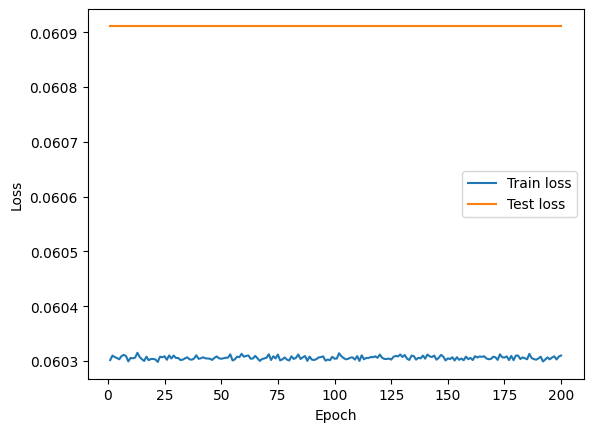

Model saved as 241117061724_model_E200_B32_LR0.01_GAMMA0.9_TRAIN0.0603_TEST0.0609.pth
Training model with batch size 32, lr 0.01, gamma 0.95
11/17 06:17:31 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.090940	Test Loss: 0.091342
11/17 06:17:38 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.090535	Test Loss: 0.090620
11/17 06:17:45 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.090111	Test Loss: 0.090620
11/17 06:17:52 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.090115	Test Loss: 0.090620
11/17 06:17:59 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.090109	Test Loss: 0.090620
11/17 06:18:06 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.090107	Test Loss: 0.090620
11/17 06:18:13 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.090110	Test Loss: 0.090620
11/17 06:18:20 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.090106	Test Loss: 0.090620
11/17 06:18:27 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.090116	Test Loss: 0.090620
11/1

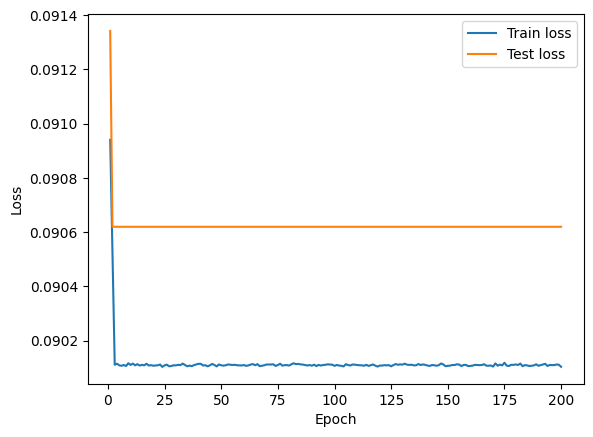

Model saved as 241117064029_model_E200_B32_LR0.01_GAMMA0.95_TRAIN0.0901_TEST0.0906.pth
Training model with batch size 32, lr 0.01, gamma 0.99
11/17 06:40:36 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047500	Test Loss: 0.047854
11/17 06:40:43 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046698	Test Loss: 0.047022
11/17 06:40:50 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046491	Test Loss: 0.047129
11/17 06:40:57 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046308	Test Loss: 0.046589
11/17 06:41:04 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046208	Test Loss: 0.046741
11/17 06:41:10 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046103	Test Loss: 0.046381
11/17 06:41:17 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046073	Test Loss: 0.046463
11/17 06:41:24 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046013	Test Loss: 0.046285
11/17 06:41:31 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045950	Test Loss: 0.046618
11/

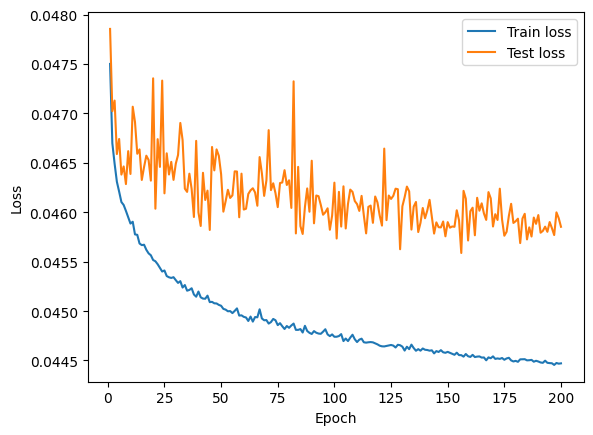

Model saved as 241117070332_model_E200_B32_LR0.01_GAMMA0.99_TRAIN0.0445_TEST0.0459.pth
Training model with batch size 32, lr 0.001, gamma 0.9
11/17 07:03:39 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047451	Test Loss: 0.047276
11/17 07:03:46 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046509	Test Loss: 0.046792
11/17 07:03:53 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046056	Test Loss: 0.046419
11/17 07:04:00 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045645	Test Loss: 0.046015
11/17 07:04:07 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045375	Test Loss: 0.046060
11/17 07:04:13 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045229	Test Loss: 0.046306
11/17 07:04:20 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045106	Test Loss: 0.045777
11/17 07:04:27 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045032	Test Loss: 0.046181
11/17 07:04:34 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044922	Test Loss: 0.045717
11/

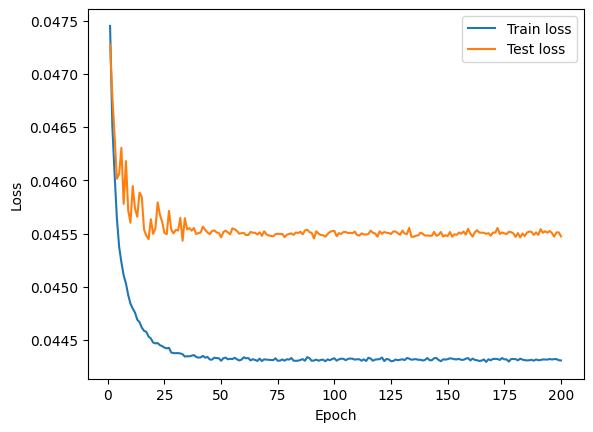

Model saved as 241117072637_model_E200_B32_LR0.001_GAMMA0.9_TRAIN0.0443_TEST0.0455.pth
Training model with batch size 32, lr 0.001, gamma 0.95
11/17 07:26:44 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047425	Test Loss: 0.047406
11/17 07:26:51 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046568	Test Loss: 0.047066
11/17 07:26:58 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046159	Test Loss: 0.046313
11/17 07:27:05 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045732	Test Loss: 0.046294
11/17 07:27:12 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045408	Test Loss: 0.046391
11/17 07:27:19 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045246	Test Loss: 0.046238
11/17 07:27:26 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045069	Test Loss: 0.045964
11/17 07:27:33 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.044986	Test Loss: 0.046447
11/17 07:27:40 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044902	Test Loss: 0.045789
11

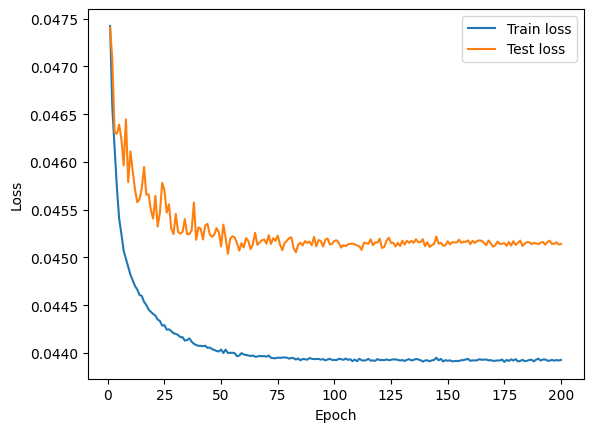

Model saved as 241117074947_model_E200_B32_LR0.001_GAMMA0.95_TRAIN0.0439_TEST0.0451.pth
Training model with batch size 32, lr 0.001, gamma 0.99
11/17 07:49:54 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047452	Test Loss: 0.047536
11/17 07:50:01 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046587	Test Loss: 0.046825
11/17 07:50:08 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046162	Test Loss: 0.046331
11/17 07:50:15 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045838	Test Loss: 0.046362
11/17 07:50:22 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045598	Test Loss: 0.046158
11/17 07:50:29 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045421	Test Loss: 0.046037
11/17 07:50:36 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045285	Test Loss: 0.045932
11/17 07:50:43 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045180	Test Loss: 0.046285
11/17 07:50:49 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045101	Test Loss: 0.046267
1

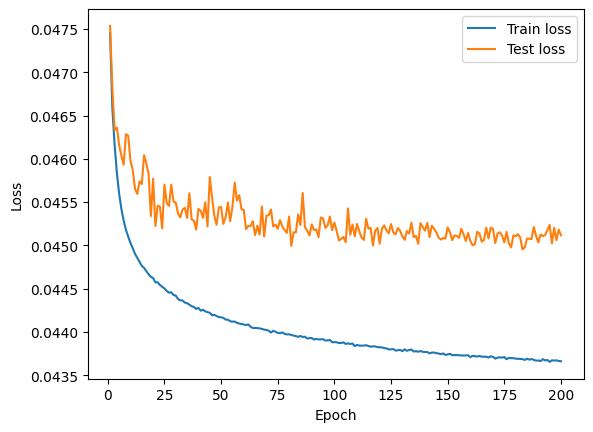

Model saved as 241117081255_model_E200_B32_LR0.001_GAMMA0.99_TRAIN0.0437_TEST0.0451.pth
Training model with batch size 32, lr 0.0001, gamma 0.9
11/17 08:13:02 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048776	Test Loss: 0.047877
11/17 08:13:09 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047164	Test Loss: 0.047470
11/17 08:13:16 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046902	Test Loss: 0.047307
11/17 08:13:23 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046751	Test Loss: 0.047218
11/17 08:13:30 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046628	Test Loss: 0.047178
11/17 08:13:36 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046512	Test Loss: 0.046901
11/17 08:13:43 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046378	Test Loss: 0.046847
11/17 08:13:50 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046297	Test Loss: 0.046803
11/17 08:13:57 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046229	Test Loss: 0.046808
1

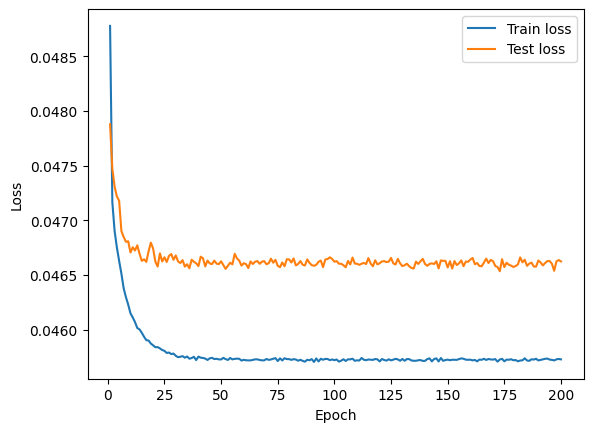

Model saved as 241117083450_model_E200_B32_LR0.0001_GAMMA0.9_TRAIN0.0457_TEST0.0466.pth
Training model with batch size 32, lr 0.0001, gamma 0.95
11/17 08:34:56 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048837	Test Loss: 0.047944
11/17 08:35:01 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047144	Test Loss: 0.047484
11/17 08:35:07 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046856	Test Loss: 0.047308
11/17 08:35:12 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046636	Test Loss: 0.047291
11/17 08:35:18 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046484	Test Loss: 0.046932
11/17 08:35:23 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046336	Test Loss: 0.046996
11/17 08:35:29 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046265	Test Loss: 0.046738
11/17 08:35:34 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046140	Test Loss: 0.046789
11/17 08:35:40 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046073	Test Loss: 0.046720


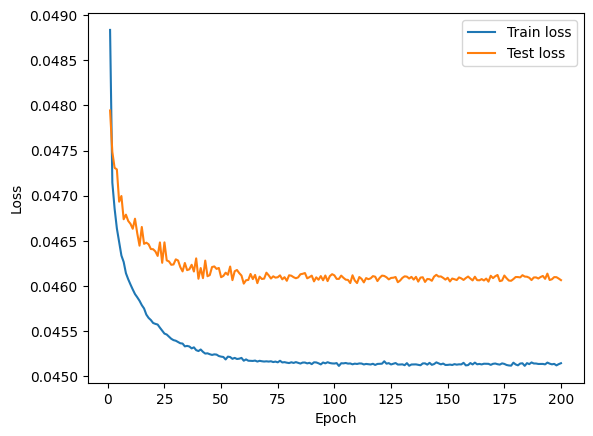

Model saved as 241117085313_model_E200_B32_LR0.0001_GAMMA0.95_TRAIN0.0451_TEST0.0461.pth
Training model with batch size 32, lr 0.0001, gamma 0.99
11/17 08:53:19 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048780	Test Loss: 0.047946
11/17 08:53:24 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047231	Test Loss: 0.047640
11/17 08:53:30 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047008	Test Loss: 0.047496
11/17 08:53:35 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046856	Test Loss: 0.047271
11/17 08:53:41 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046707	Test Loss: 0.047210
11/17 08:53:46 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046569	Test Loss: 0.047026
11/17 08:53:52 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046410	Test Loss: 0.046924
11/17 08:53:57 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046274	Test Loss: 0.047002
11/17 08:54:03 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046163	Test Loss: 0.046694

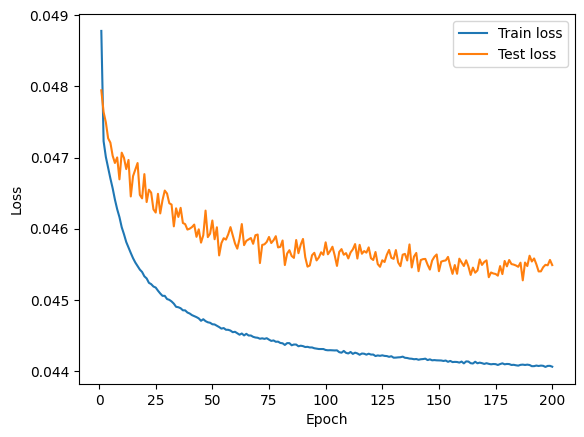

Model saved as 241117091132_model_E200_B32_LR0.0001_GAMMA0.99_TRAIN0.0441_TEST0.0455.pth
Training model with batch size 64, lr 0.01, gamma 0.9
11/17 09:11:36 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.060369	Test Loss: 0.060980
11/17 09:11:40 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060980
11/17 09:11:44 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/17 09:11:47 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/17 09:11:51 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/17 09:11:55 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.060303	Test Loss: 0.060980
11/17 09:11:59 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.060306	Test Loss: 0.060980
11/17 09:12:02 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/17 09:12:06 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060980
11

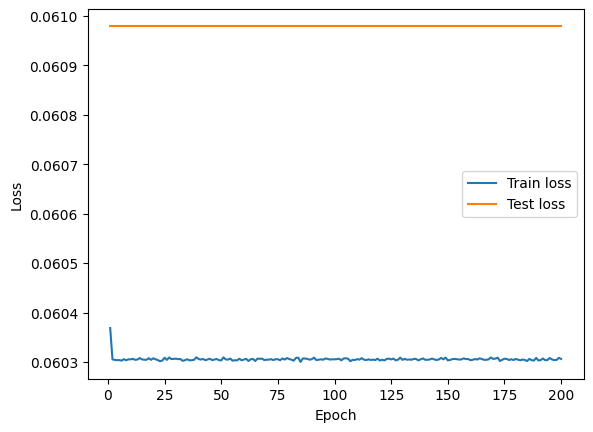

Model saved as 241117092400_model_E200_B64_LR0.01_GAMMA0.9_TRAIN0.0603_TEST0.0610.pth
Training model with batch size 64, lr 0.01, gamma 0.95
11/17 09:24:04 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.078710	Test Loss: 0.079097
11/17 09:24:07 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.078804	Test Loss: 0.079097
11/17 09:24:11 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.078806	Test Loss: 0.079097
11/17 09:24:15 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.078807	Test Loss: 0.079097
11/17 09:24:19 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.078804	Test Loss: 0.079097
11/17 09:24:22 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.078805	Test Loss: 0.079097
11/17 09:24:26 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.078805	Test Loss: 0.079097
11/17 09:24:30 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.078844	Test Loss: 0.079982
11/17 09:24:34 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.078897	Test Loss: 0.079982
11/1

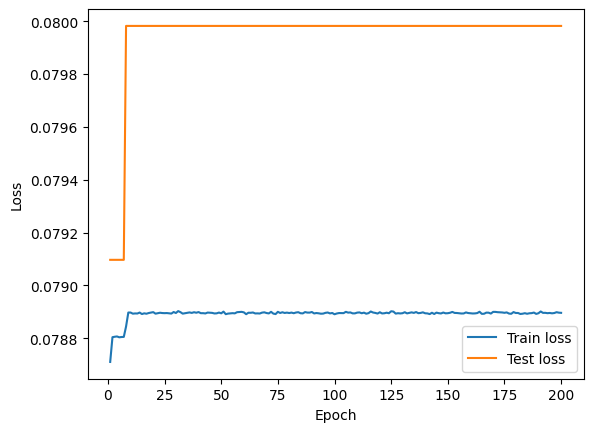

Model saved as 241117093830_model_E200_B64_LR0.01_GAMMA0.95_TRAIN0.0789_TEST0.0800.pth
Training model with batch size 64, lr 0.01, gamma 0.99
11/17 09:38:34 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.060300	Test Loss: 0.060980
11/17 09:38:39 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.060307	Test Loss: 0.060980
11/17 09:38:43 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/17 09:38:48 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.060307	Test Loss: 0.060980
11/17 09:38:52 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/17 09:38:57 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060980
11/17 09:39:01 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.060306	Test Loss: 0.060980
11/17 09:39:05 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.060980
11/17 09:39:10 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.060980
11/

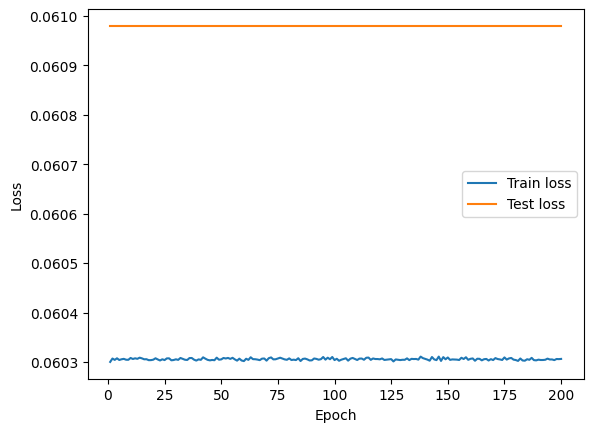

Model saved as 241117095323_model_E200_B64_LR0.01_GAMMA0.99_TRAIN0.0603_TEST0.0610.pth
Training model with batch size 64, lr 0.001, gamma 0.9
11/17 09:53:28 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047635	Test Loss: 0.047426
11/17 09:53:32 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046591	Test Loss: 0.046905
11/17 09:53:37 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046184	Test Loss: 0.047047
11/17 09:53:41 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045820	Test Loss: 0.046441
11/17 09:53:46 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045517	Test Loss: 0.046360
11/17 09:53:50 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045299	Test Loss: 0.046314
11/17 09:53:55 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045163	Test Loss: 0.045774
11/17 09:53:59 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045014	Test Loss: 0.045952
11/17 09:54:04 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044928	Test Loss: 0.045908
11/

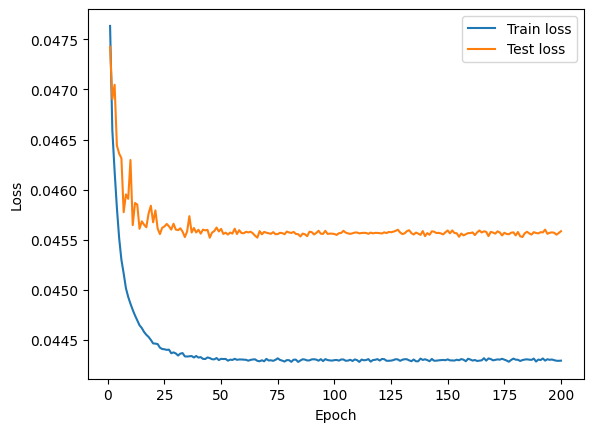

Model saved as 241117100705_model_E200_B64_LR0.001_GAMMA0.9_TRAIN0.0443_TEST0.0456.pth
Training model with batch size 64, lr 0.001, gamma 0.95
11/17 10:07:09 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047852	Test Loss: 0.047617
11/17 10:07:13 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046708	Test Loss: 0.046986
11/17 10:07:16 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046351	Test Loss: 0.046758
11/17 10:07:20 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046019	Test Loss: 0.046421
11/17 10:07:24 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045699	Test Loss: 0.046179
11/17 10:07:28 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045440	Test Loss: 0.046176
11/17 10:07:31 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045293	Test Loss: 0.046245
11/17 10:07:35 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045166	Test Loss: 0.045780
11/17 10:07:39 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045053	Test Loss: 0.045950
11

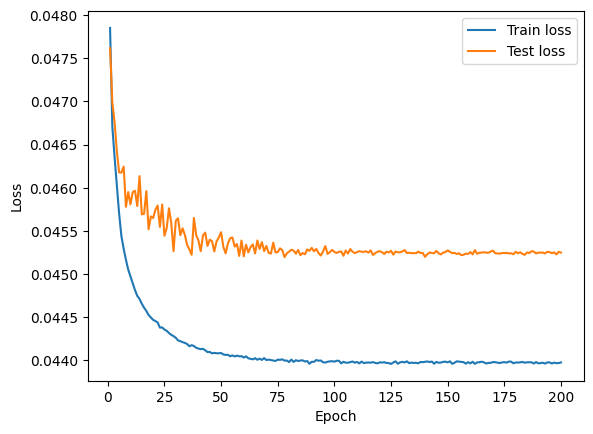

Model saved as 241117101940_model_E200_B64_LR0.001_GAMMA0.95_TRAIN0.0440_TEST0.0452.pth
Training model with batch size 64, lr 0.001, gamma 0.99
11/17 10:19:44 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047688	Test Loss: 0.047397
11/17 10:19:47 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046690	Test Loss: 0.047559
11/17 10:19:51 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046355	Test Loss: 0.046694
11/17 10:19:55 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045986	Test Loss: 0.046494
11/17 10:19:59 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045629	Test Loss: 0.046606
11/17 10:20:02 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045430	Test Loss: 0.046472
11/17 10:20:06 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045279	Test Loss: 0.046326
11/17 10:20:10 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045177	Test Loss: 0.046139
11/17 10:20:13 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.044974	Test Loss: 0.045744
1

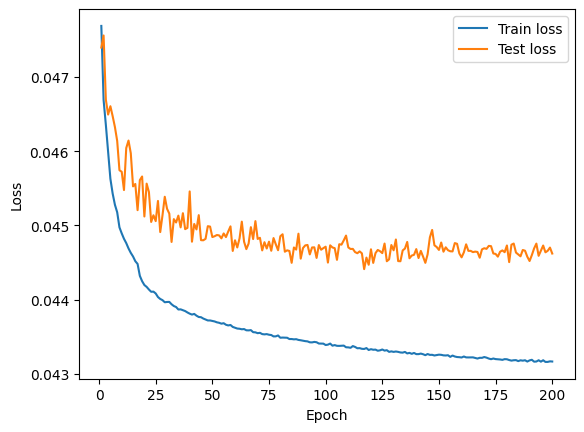

Model saved as 241117103219_model_E200_B64_LR0.001_GAMMA0.99_TRAIN0.0432_TEST0.0446.pth
Training model with batch size 64, lr 0.0001, gamma 0.9
11/17 10:32:23 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.049878	Test Loss: 0.048253
11/17 10:32:27 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047357	Test Loss: 0.047831
11/17 10:32:31 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047066	Test Loss: 0.047681
11/17 10:32:35 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046923	Test Loss: 0.047407
11/17 10:32:38 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046797	Test Loss: 0.047338
11/17 10:32:42 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046702	Test Loss: 0.047313
11/17 10:32:46 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046630	Test Loss: 0.047377
11/17 10:32:50 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046568	Test Loss: 0.047293
11/17 10:32:53 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046509	Test Loss: 0.047180
1

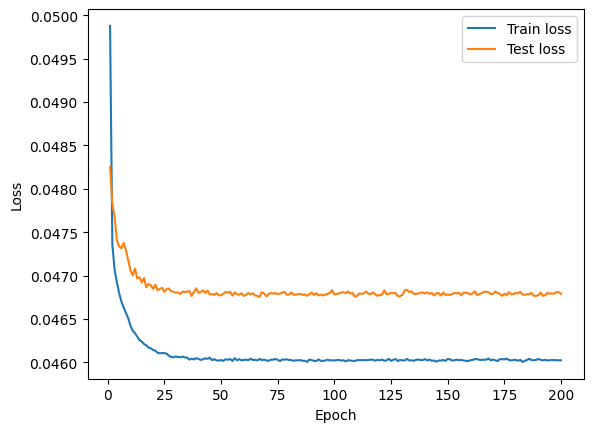

Model saved as 241117104536_model_E200_B64_LR0.0001_GAMMA0.9_TRAIN0.0460_TEST0.0468.pth
Training model with batch size 64, lr 0.0001, gamma 0.95
11/17 10:45:40 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.051321	Test Loss: 0.050240
11/17 10:45:44 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.049140	Test Loss: 0.048150
11/17 10:45:47 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047333	Test Loss: 0.047816
11/17 10:45:51 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047039	Test Loss: 0.047688
11/17 10:45:55 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046854	Test Loss: 0.047471
11/17 10:45:59 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046740	Test Loss: 0.047307
11/17 10:46:03 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046643	Test Loss: 0.047283
11/17 10:46:07 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046551	Test Loss: 0.047258
11/17 10:46:11 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046477	Test Loss: 0.047098


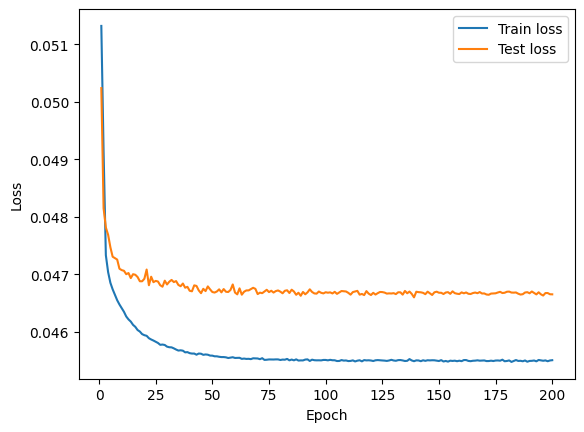

Model saved as 241117105830_model_E200_B64_LR0.0001_GAMMA0.95_TRAIN0.0455_TEST0.0467.pth
Training model with batch size 64, lr 0.0001, gamma 0.99
11/17 10:58:34 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.049979	Test Loss: 0.048346
11/17 10:58:38 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047443	Test Loss: 0.047833
11/17 10:58:42 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047161	Test Loss: 0.047601
11/17 10:58:46 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046974	Test Loss: 0.047368
11/17 10:58:50 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046812	Test Loss: 0.047260
11/17 10:58:54 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046631	Test Loss: 0.047198
11/17 10:58:57 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046468	Test Loss: 0.047016
11/17 10:59:01 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046332	Test Loss: 0.046805
11/17 10:59:05 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046219	Test Loss: 0.046753

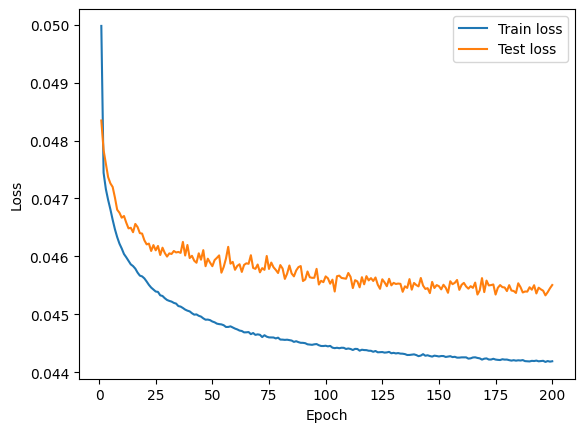

Model saved as 241117111150_model_E200_B64_LR0.0001_GAMMA0.99_TRAIN0.0442_TEST0.0455.pth
Training model with batch size 128, lr 0.01, gamma 0.9
11/17 11:11:53 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.060396	Test Loss: 0.061114
11/17 11:11:57 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.060303	Test Loss: 0.061114
11/17 11:12:01 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.061114
11/17 11:12:05 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.061114
11/17 11:12:08 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.061114
11/17 11:12:12 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.060306	Test Loss: 0.061114
11/17 11:12:16 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.060303	Test Loss: 0.061114
11/17 11:12:20 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.060305	Test Loss: 0.061114
11/17 11:12:24 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.060304	Test Loss: 0.061114
1

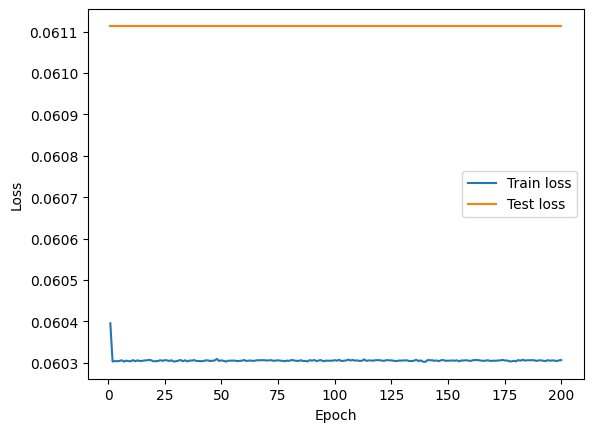

Model saved as 241117112310_model_E200_B128_LR0.01_GAMMA0.9_TRAIN0.0603_TEST0.0611.pth
Training model with batch size 128, lr 0.01, gamma 0.95
11/17 11:23:13 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048546	Test Loss: 0.047571
11/17 11:23:17 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046731	Test Loss: 0.047211
11/17 11:23:20 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046369	Test Loss: 0.046803
11/17 11:23:23 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046033	Test Loss: 0.046499
11/17 11:23:27 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045794	Test Loss: 0.046604
11/17 11:23:30 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045577	Test Loss: 0.046817
11/17 11:23:33 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045461	Test Loss: 0.046152
11/17 11:23:37 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045316	Test Loss: 0.046233
11/17 11:23:40 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045131	Test Loss: 0.045725
11

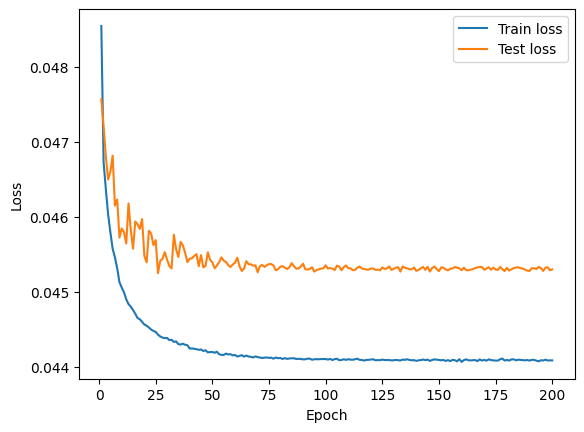

Model saved as 241117113436_model_E200_B128_LR0.01_GAMMA0.95_TRAIN0.0441_TEST0.0453.pth
Training model with batch size 128, lr 0.01, gamma 0.99
11/17 11:34:40 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.047897	Test Loss: 0.047581
11/17 11:34:44 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046714	Test Loss: 0.047369
11/17 11:34:48 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046387	Test Loss: 0.046890
11/17 11:34:52 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046108	Test Loss: 0.046727
11/17 11:34:55 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045879	Test Loss: 0.047802
11/17 11:34:59 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045696	Test Loss: 0.046262
11/17 11:35:03 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045559	Test Loss: 0.047274
11/17 11:35:07 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045455	Test Loss: 0.046755
11/17 11:35:10 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045373	Test Loss: 0.046841
1

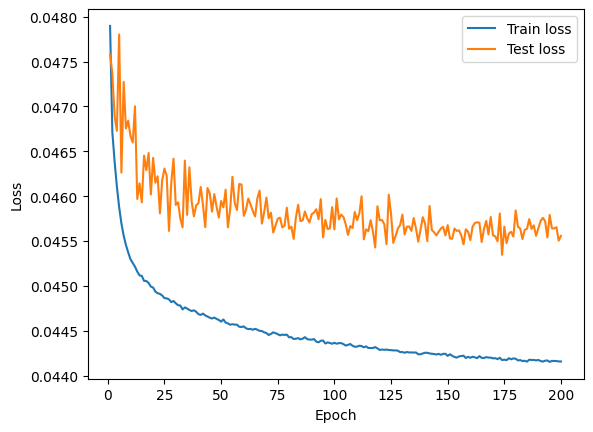

Model saved as 241117114609_model_E200_B128_LR0.01_GAMMA0.99_TRAIN0.0442_TEST0.0456.pth
Training model with batch size 128, lr 0.001, gamma 0.9
11/17 11:46:12 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048158	Test Loss: 0.047868
11/17 11:46:15 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046724	Test Loss: 0.047508
11/17 11:46:19 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046359	Test Loss: 0.046939
11/17 11:46:22 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046119	Test Loss: 0.046807
11/17 11:46:25 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045922	Test Loss: 0.046557
11/17 11:46:29 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045785	Test Loss: 0.046543
11/17 11:46:32 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045672	Test Loss: 0.046339
11/17 11:46:35 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045512	Test Loss: 0.046349
11/17 11:46:38 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045420	Test Loss: 0.046265
1

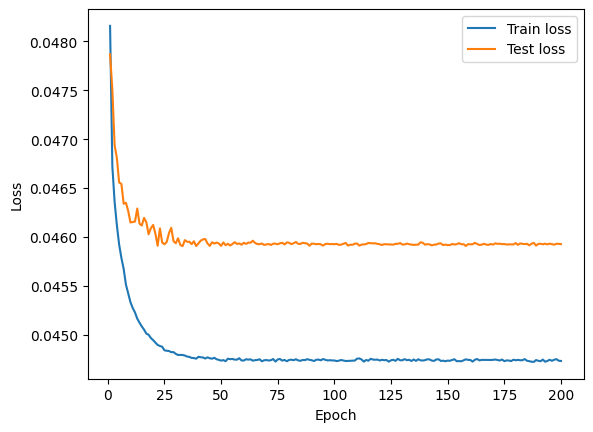

Model saved as 241117115710_model_E200_B128_LR0.001_GAMMA0.9_TRAIN0.0447_TEST0.0459.pth
Training model with batch size 128, lr 0.001, gamma 0.95
11/17 11:57:14 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048233	Test Loss: 0.047802
11/17 11:57:17 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046832	Test Loss: 0.047830
11/17 11:57:20 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046587	Test Loss: 0.047517
11/17 11:57:24 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046329	Test Loss: 0.046999
11/17 11:57:27 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046028	Test Loss: 0.047241
11/17 11:57:30 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045825	Test Loss: 0.047081
11/17 11:57:34 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045639	Test Loss: 0.046843
11/17 11:57:37 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045437	Test Loss: 0.046734
11/17 11:57:40 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045324	Test Loss: 0.046271


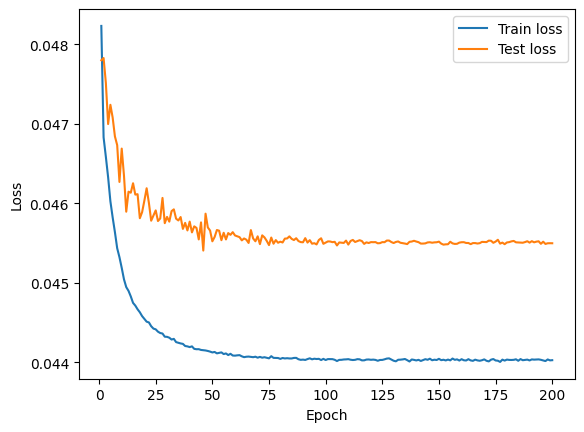

Model saved as 241117120812_model_E200_B128_LR0.001_GAMMA0.95_TRAIN0.0440_TEST0.0455.pth
Training model with batch size 128, lr 0.001, gamma 0.99
11/17 12:08:16 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048245	Test Loss: 0.048213
11/17 12:08:19 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046824	Test Loss: 0.047409
11/17 12:08:22 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046521	Test Loss: 0.047463
11/17 12:08:25 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046277	Test Loss: 0.046893
11/17 12:08:29 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046076	Test Loss: 0.047005
11/17 12:08:32 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045921	Test Loss: 0.046673
11/17 12:08:35 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045809	Test Loss: 0.047433
11/17 12:08:39 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045702	Test Loss: 0.046666
11/17 12:08:42 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045572	Test Loss: 0.047150

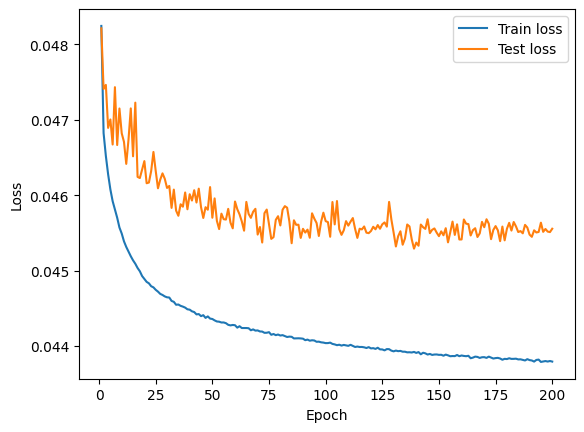

Model saved as 241117121914_model_E200_B128_LR0.001_GAMMA0.99_TRAIN0.0438_TEST0.0456.pth
Training model with batch size 128, lr 0.0001, gamma 0.9
11/17 12:19:17 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.051119	Test Loss: 0.048851
11/17 12:19:20 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047758	Test Loss: 0.048268
11/17 12:19:24 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047388	Test Loss: 0.047989
11/17 12:19:27 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047181	Test Loss: 0.047971
11/17 12:19:30 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.047044	Test Loss: 0.047794
11/17 12:19:34 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046948	Test Loss: 0.047718
11/17 12:19:37 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046872	Test Loss: 0.047558
11/17 12:19:40 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046800	Test Loss: 0.047636
11/17 12:19:44 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046762	Test Loss: 0.047570

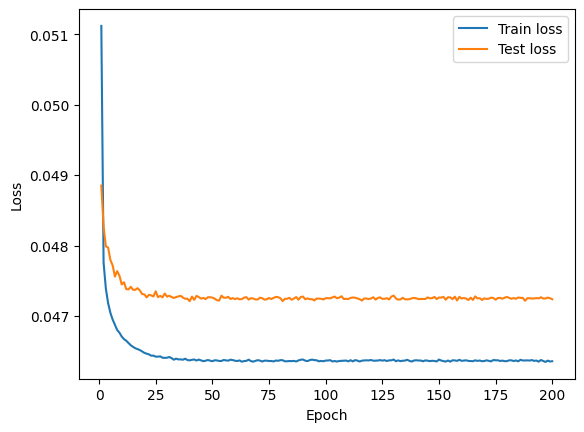

Model saved as 241117123016_model_E200_B128_LR0.0001_GAMMA0.9_TRAIN0.0464_TEST0.0472.pth
Training model with batch size 128, lr 0.0001, gamma 0.95
11/17 12:30:19 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.052955	Test Loss: 0.049158
11/17 12:30:22 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047824	Test Loss: 0.048136
11/17 12:30:26 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047311	Test Loss: 0.047913
11/17 12:30:29 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047136	Test Loss: 0.047762
11/17 12:30:32 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.047003	Test Loss: 0.047635
11/17 12:30:35 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046925	Test Loss: 0.047551
11/17 12:30:39 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046833	Test Loss: 0.047420
11/17 12:30:42 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046748	Test Loss: 0.047457
11/17 12:30:45 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046669	Test Loss: 0.04738

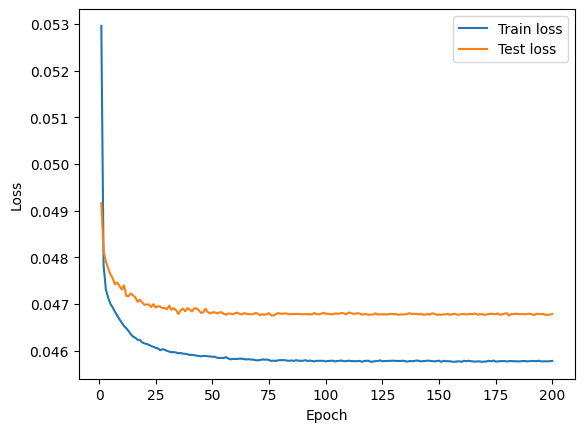

Model saved as 241117124118_model_E200_B128_LR0.0001_GAMMA0.95_TRAIN0.0458_TEST0.0468.pth
Training model with batch size 128, lr 0.0001, gamma 0.99
11/17 12:41:21 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.051078	Test Loss: 0.048834
11/17 12:41:25 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047746	Test Loss: 0.048337
11/17 12:41:28 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047269	Test Loss: 0.047806
11/17 12:41:31 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047033	Test Loss: 0.047673
11/17 12:41:35 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046919	Test Loss: 0.047557
11/17 12:41:38 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046811	Test Loss: 0.047611
11/17 12:41:41 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046742	Test Loss: 0.047626
11/17 12:41:44 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046637	Test Loss: 0.047426
11/17 12:41:48 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046565	Test Loss: 0.0475

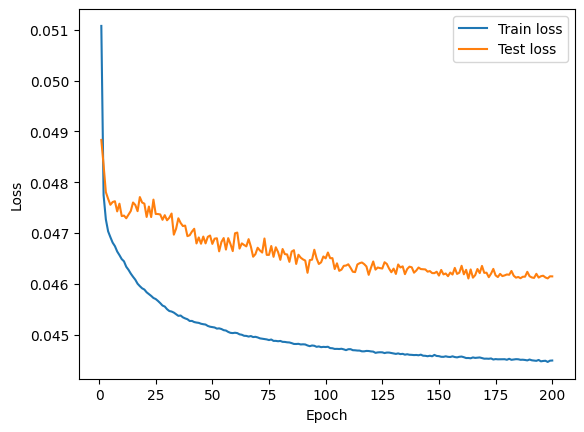

Model saved as 241117125354_model_E200_B128_LR0.0001_GAMMA0.99_TRAIN0.0445_TEST0.0461.pth
Training model with batch size 256, lr 0.01, gamma 0.9
11/17 12:54:00 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048938	Test Loss: 0.048129
11/17 12:54:04 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046558	Test Loss: 0.048231
11/17 12:54:07 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046108	Test Loss: 0.046888
11/17 12:54:11 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.045829	Test Loss: 0.046883
11/17 12:54:15 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045631	Test Loss: 0.046376
11/17 12:54:24 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045493	Test Loss: 0.046609
11/17 12:55:25 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045402	Test Loss: 0.046173
11/17 12:56:43 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045239	Test Loss: 0.046137
11/17 12:58:27 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045139	Test Loss: 0.046422


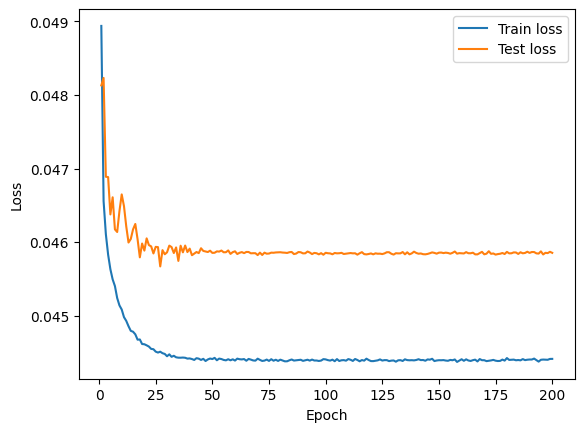

Model saved as 241117143703_model_E200_B256_LR0.01_GAMMA0.9_TRAIN0.0444_TEST0.0459.pth
Training model with batch size 256, lr 0.01, gamma 0.95
11/17 14:37:07 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.049582	Test Loss: 0.047919
11/17 14:37:10 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046758	Test Loss: 0.048274
11/17 14:37:14 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046491	Test Loss: 0.047512
11/17 14:37:17 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046290	Test Loss: 0.047095
11/17 14:37:21 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046036	Test Loss: 0.046880
11/17 14:37:24 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045838	Test Loss: 0.047825
11/17 14:37:28 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045685	Test Loss: 0.047011
11/17 14:37:31 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045543	Test Loss: 0.046260
11/17 14:37:34 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045363	Test Loss: 0.047829
11

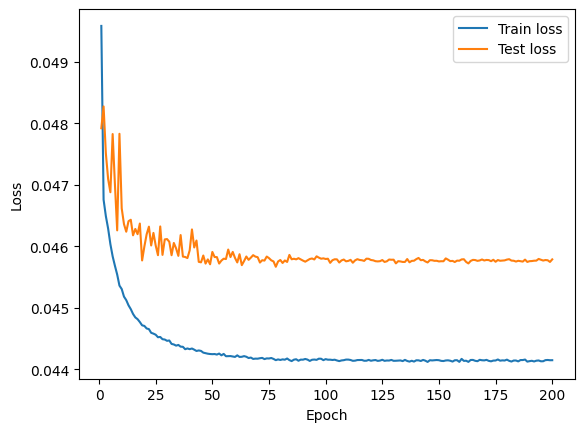

Model saved as 241117144750_model_E200_B256_LR0.01_GAMMA0.95_TRAIN0.0442_TEST0.0458.pth
Training model with batch size 256, lr 0.01, gamma 0.99
11/17 14:47:54 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.050216	Test Loss: 0.048284
11/17 14:47:57 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046875	Test Loss: 0.047949
11/17 14:48:00 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046482	Test Loss: 0.047022
11/17 14:48:03 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046112	Test Loss: 0.047402
11/17 14:48:06 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.045875	Test Loss: 0.046776
11/17 14:48:09 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045619	Test Loss: 0.046214
11/17 14:48:12 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045466	Test Loss: 0.046397
11/17 14:48:15 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045331	Test Loss: 0.046354
11/17 14:48:18 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045212	Test Loss: 0.046660
1

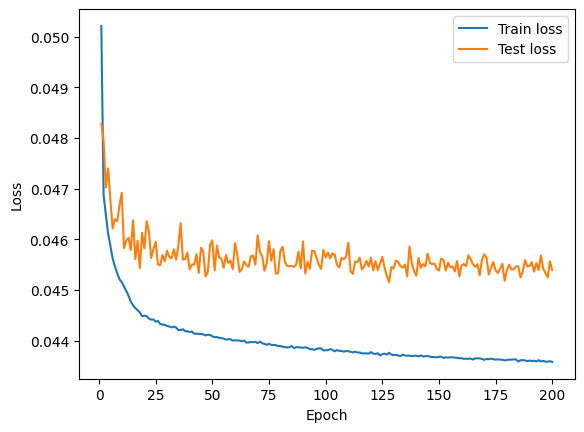

Model saved as 241117145810_model_E200_B256_LR0.01_GAMMA0.99_TRAIN0.0436_TEST0.0454.pth
Training model with batch size 256, lr 0.001, gamma 0.9
11/17 14:58:13 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048879	Test Loss: 0.048274
11/17 14:58:16 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047001	Test Loss: 0.047730
11/17 14:58:19 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046723	Test Loss: 0.047498
11/17 14:58:22 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046546	Test Loss: 0.047244
11/17 14:58:25 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046303	Test Loss: 0.047272
11/17 14:58:28 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046183	Test Loss: 0.046945
11/17 14:58:31 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.046068	Test Loss: 0.046798
11/17 14:58:34 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045955	Test Loss: 0.046754
11/17 14:58:38 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045883	Test Loss: 0.046680
1

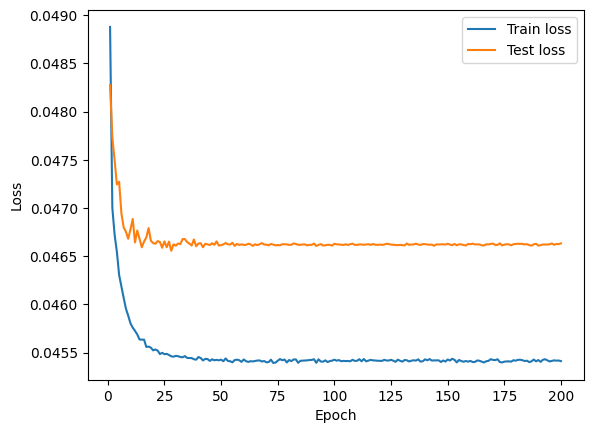

Model saved as 241117150829_model_E200_B256_LR0.001_GAMMA0.9_TRAIN0.0454_TEST0.0466.pth
Training model with batch size 256, lr 0.001, gamma 0.95
11/17 15:08:33 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048929	Test Loss: 0.048113
11/17 15:08:36 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.047006	Test Loss: 0.047893
11/17 15:08:39 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046680	Test Loss: 0.047424
11/17 15:08:42 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046398	Test Loss: 0.047034
11/17 15:08:45 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046138	Test Loss: 0.047000
11/17 15:08:48 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.045920	Test Loss: 0.046631
11/17 15:08:51 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045778	Test Loss: 0.046403
11/17 15:08:54 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045659	Test Loss: 0.046857
11/17 15:08:57 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045583	Test Loss: 0.046756


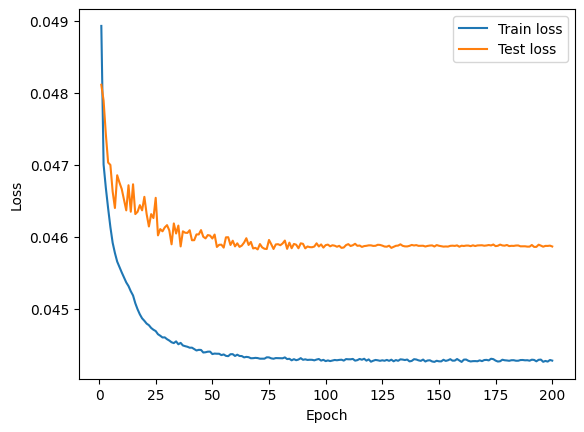

Model saved as 241117151849_model_E200_B256_LR0.001_GAMMA0.95_TRAIN0.0443_TEST0.0459.pth
Training model with batch size 256, lr 0.001, gamma 0.99
11/17 15:18:52 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.048789	Test Loss: 0.048418
11/17 15:18:55 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.046985	Test Loss: 0.047622
11/17 15:18:58 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.046673	Test Loss: 0.047584
11/17 15:19:01 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.046438	Test Loss: 0.047207
11/17 15:19:04 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.046171	Test Loss: 0.047665
11/17 15:19:07 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.046007	Test Loss: 0.047256
11/17 15:19:11 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.045793	Test Loss: 0.046892
11/17 15:19:14 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.045710	Test Loss: 0.046882
11/17 15:19:17 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.045643	Test Loss: 0.046709

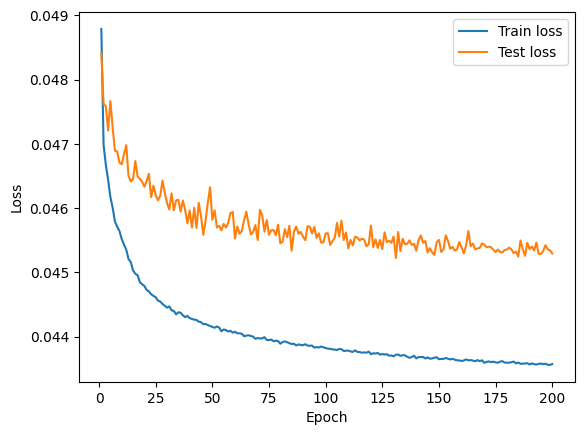

Model saved as 241117152907_model_E200_B256_LR0.001_GAMMA0.99_TRAIN0.0436_TEST0.0453.pth
Training model with batch size 256, lr 0.0001, gamma 0.9
11/17 15:29:10 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.053837	Test Loss: 0.050218
11/17 15:29:13 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.048517	Test Loss: 0.048942
11/17 15:29:16 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047829	Test Loss: 0.048597
11/17 15:29:20 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047561	Test Loss: 0.048394
11/17 15:29:23 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.047378	Test Loss: 0.048204
11/17 15:29:26 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.047252	Test Loss: 0.048096
11/17 15:29:29 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.047146	Test Loss: 0.047917
11/17 15:29:32 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.047069	Test Loss: 0.047885
11/17 15:29:35 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046991	Test Loss: 0.047853

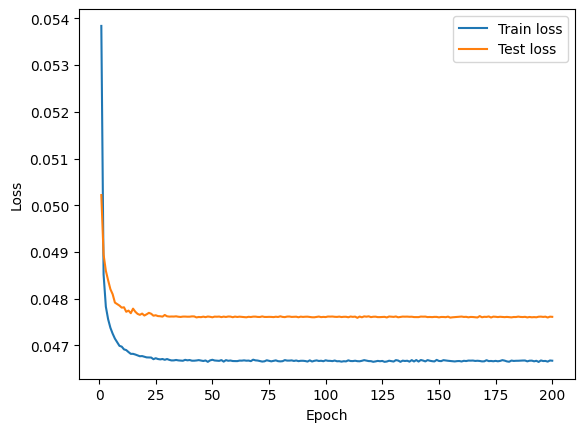

Model saved as 241117153927_model_E200_B256_LR0.0001_GAMMA0.9_TRAIN0.0467_TEST0.0476.pth
Training model with batch size 256, lr 0.0001, gamma 0.95
11/17 15:39:30 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.055302	Test Loss: 0.051937
11/17 15:39:33 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.048788	Test Loss: 0.048976
11/17 15:39:36 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047826	Test Loss: 0.048545
11/17 15:39:39 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047487	Test Loss: 0.048370
11/17 15:39:42 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.047279	Test Loss: 0.048148
11/17 15:39:45 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.047167	Test Loss: 0.047958
11/17 15:39:49 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.047056	Test Loss: 0.047904
11/17 15:39:52 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.046962	Test Loss: 0.047849
11/17 15:39:55 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046906	Test Loss: 0.04784

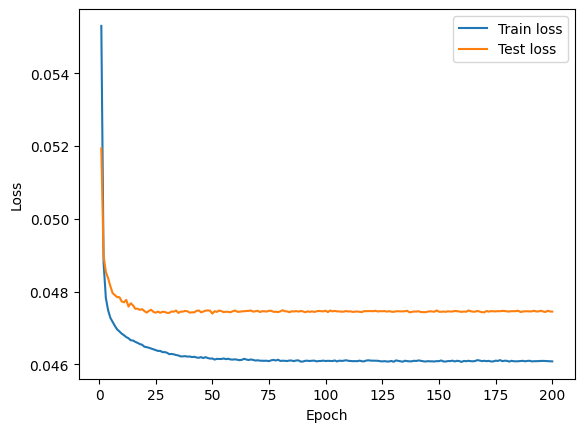

Model saved as 241117155023_model_E200_B256_LR0.0001_GAMMA0.95_TRAIN0.0461_TEST0.0475.pth
Training model with batch size 256, lr 0.0001, gamma 0.99
11/17 15:50:26 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 0.054320	Test Loss: 0.049645
11/17 15:50:29 Train Epoch:    2 [49262/49262 (100%)]	Train Loss: 0.048237	Test Loss: 0.048885
11/17 15:50:33 Train Epoch:    3 [49262/49262 (100%)]	Train Loss: 0.047796	Test Loss: 0.048530
11/17 15:50:36 Train Epoch:    4 [49262/49262 (100%)]	Train Loss: 0.047516	Test Loss: 0.048294
11/17 15:50:39 Train Epoch:    5 [49262/49262 (100%)]	Train Loss: 0.047368	Test Loss: 0.048250
11/17 15:50:42 Train Epoch:    6 [49262/49262 (100%)]	Train Loss: 0.047234	Test Loss: 0.048116
11/17 15:50:45 Train Epoch:    7 [49262/49262 (100%)]	Train Loss: 0.047145	Test Loss: 0.048015
11/17 15:50:48 Train Epoch:    8 [49262/49262 (100%)]	Train Loss: 0.047060	Test Loss: 0.048102
11/17 15:50:51 Train Epoch:    9 [49262/49262 (100%)]	Train Loss: 0.046986	Test Loss: 0.0480

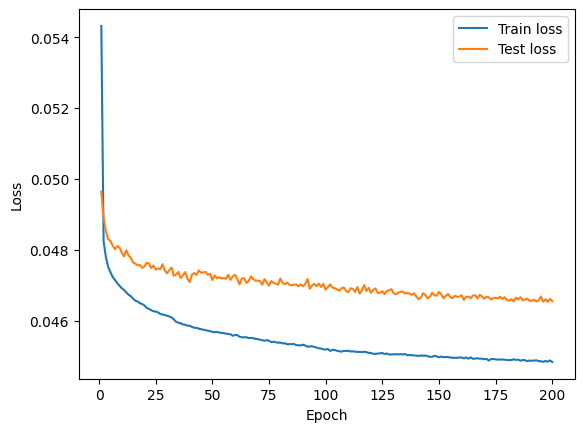

Model saved as 241117160042_model_E200_B256_LR0.0001_GAMMA0.99_TRAIN0.0448_TEST0.0465.pth


In [26]:
# Train the model
train_losses, test_losses = [], []
for batch_size in BATCH_SIZE:
    for lr in LR:
        for gamma in GAMMA:
            print(f"Training model with batch size {batch_size}, lr {lr}, gamma {gamma}")
            model = Model()
            model.to(DEVICE)

            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

            train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

            # Plot losses
            plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
            plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

            # Save the model
            model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_E{EPOCHS}_B{batch_size}_LR{lr}_GAMMA{gamma}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"
            torch.save(model.state_dict(), "models/parametric/" + model_name)
            print(f"Model saved as {model_name}")

            train_losses.append(train_loss)
            test_losses.append(test_loss)


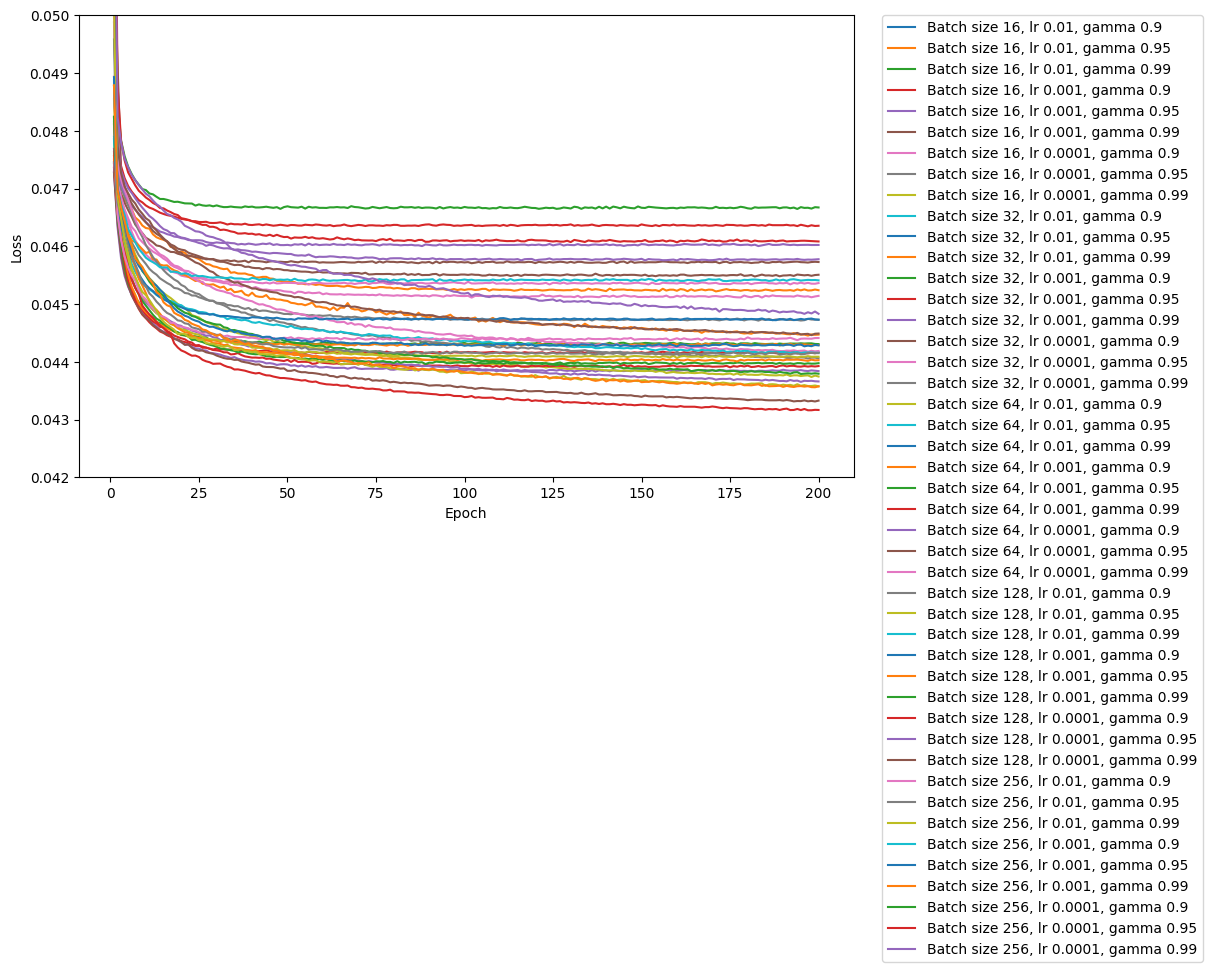

In [38]:
# Plot losses
fig = plt.figure(figsize=(10, 6))
m = -1
for i in range(len(BATCH_SIZE)):
    for j in range(len(LR)):
        for k in range(len(GAMMA)):
            m += 1
            plt.plot(
                range(1, EPOCHS + 1),
                train_losses[m],
                label=f"Batch size {BATCH_SIZE[i]}, lr {LR[j]}, gamma {GAMMA[k]}",
            )

# Adjust y-axis limits
plt.ylim(0.042, 0.05)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.45, 1), loc="upper right", borderaxespad=0)
plt.show()


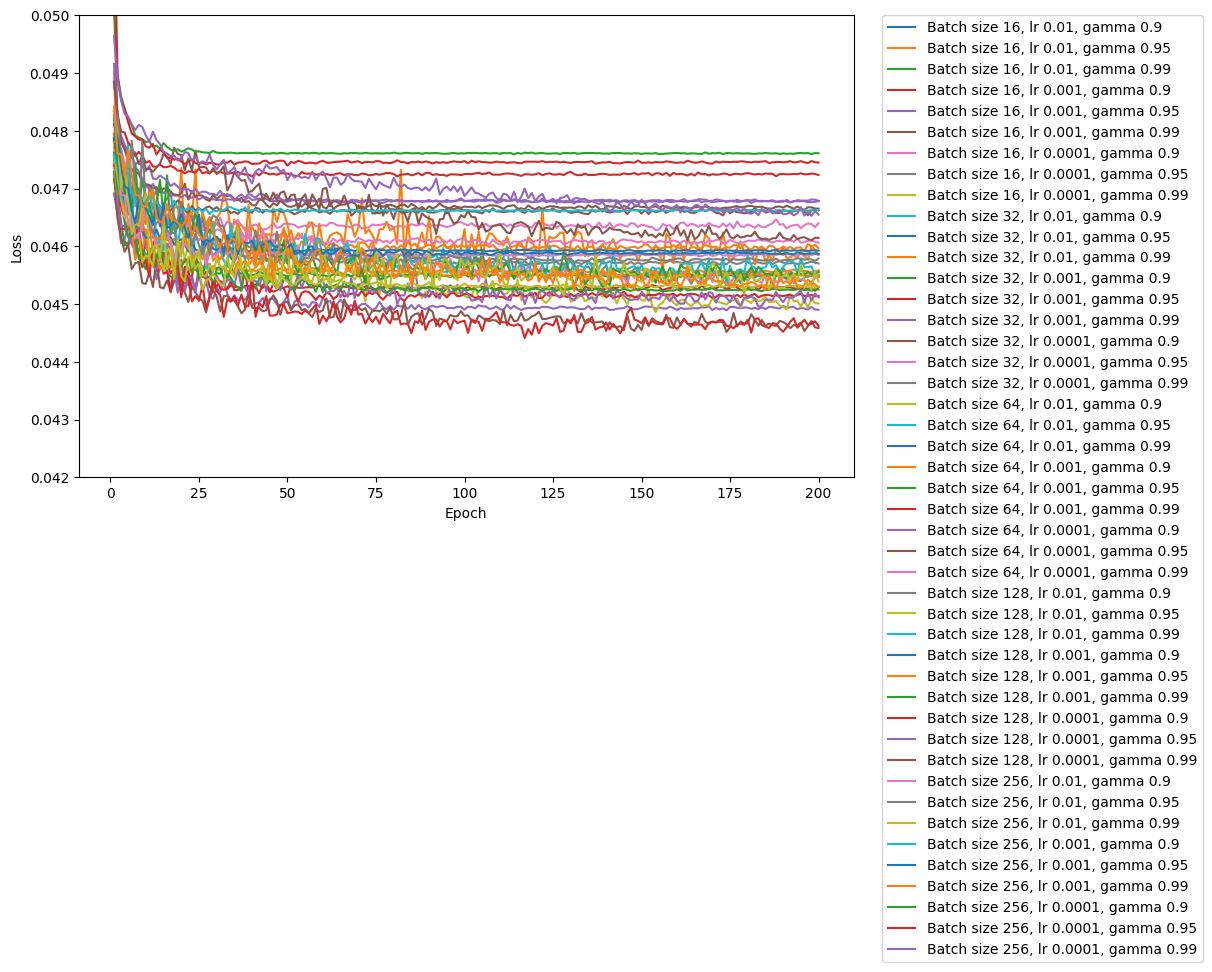

In [37]:
# Plot losses
fig = plt.figure(figsize=(10, 6))
m = -1
for i in range(len(BATCH_SIZE)):
    for j in range(len(LR)):
        for k in range(len(GAMMA)):
            m += 1
            plt.plot(
                range(1, EPOCHS + 1),
                test_losses[m],
                label=f"Batch size {BATCH_SIZE[i]}, lr {LR[j]}, gamma {GAMMA[k]}",
            )

# Adjust y-axis limits
plt.ylim(0.042, 0.05)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.45, 1), loc="upper right", borderaxespad=0)
plt.show()